# エントロピーを含めたgreedy方策

強化学習の次の行動を選ぶとき, オフポリシー法(Q学習など)の行動を選ぶ際に現在の行動価値関数に対して行動に対しての $\max$ で次の行動を選択する段階があります．その際にエントロピー項 $p\log{p}$ を含めるとソフトマックス関数になることが知られています．詳しくはこちらの[論文](https://arxiv.org/abs/2003.14089)のappendixAを見てください．

簡潔に説明すると, log-sum-exp 関数 $\log{\sum_{i=1}^{n}e^{x_{i}}}$ をルジャンドル変換すると,変換された式は $\frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}$ となります. 変換された式を $y_i$ とおくとルジャンドル変換の返還式に対しての最適な $y$ を元のlog-sum-exp 関数に代入すると $\sum_{i=1}^{n}y_i\log{y_i}$ となります．

上の説明を受けてもピンとこないので，まずはルジャンドル変換の説明をしていきます．

**ルジャンドル変換**とは下に凸な関数は**傾き**と**y切片**の値で指定される接線の集合で表現できるということです．

定義はある関数 $f(x)$ があり, それにルジャンドル変換すると新しい関数 $g(p) = \min_x(px - f(x))$ の式ができるということです．

上の式の意味はグラフで示していきます．

今回の $f(x)$は $x^2 + 2$とします．

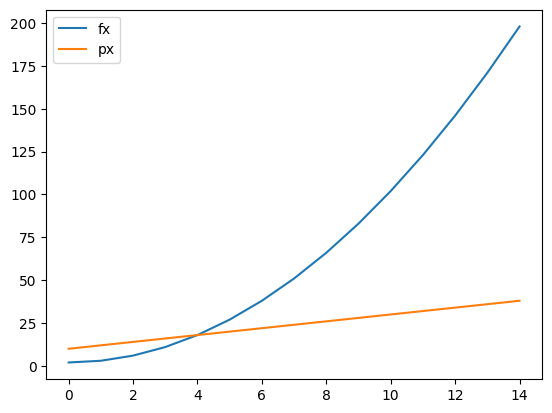

In [1]:
import numpy as np
import matplotlib.pyplot as plt

fx = lambda x : x ** 2 + 2
x = np.arange(0,15)
y = fx(x)
px = lambda x : 2 * x + 10
y_dash = px(x)
plt.plot(x,y,label='fx')
plt.plot(x,y_dash,label= 'px')
plt.legend()
plt.show()


上のグラフからルジャンドル変換の式を思い出してみると $p(x)$ と $f(x)$ の $x$　に対して1番が差が小さいということは $f(x)$ に対しての接線であることがわかります．

つまり, 傾きpによって $f(x)$ の接線の集合が作られるということです．

pは $g(p)$ に対しての微分で求まります．

このような作業をlog-sum-expで行うとエントロピー式とソフトマックス関数が一緒のことがわかります．

In [2]:
import numpy as np
from typing import NamedTuple

S = 5 #state_size
A = 2  #action_size
S_array = np.arange(S) #state_set
A_array = np.arange(A) #action_set
gamma = 0.9

rew = np.random.rand(S,A) * 10 #報酬

P = np.random.rand(S*A, S) #遷移確率
P = P / np.sum(P,axis=-1,keepdims=True)
P = P.reshape(S,A,S)
np.testing.assert_almost_equal(P.sum(axis=-1),1) #確率1になっているか確認

# MDPの定義

class MDP(NamedTuple):
    S_array : np.array
    A_array : np.array
    gamma : float
    rew : np.array
    P : np.array

    @property
    def S(self) -> int:
        return len(self.S_array)

    @property
    def A(self) -> int:
        return len(self.A_array)

mdp = MDP(S_array,A_array,gamma,rew,P)

In [11]:
import jax
import jax.numpy as jnp


@jax.jit
def Bellman_expected_operator(mdp:MDP, q:jnp.array, pi:np.array):
    S,A = mdp.S,mdp.A
    assert q.shape == (S,A)
    assert pi.shape == (S,A)
    # 行動のサメーション取ると行動価値関数から価値関数になる．
    v = (pi * q).sum(axis=1)
    P_v = mdp.P @ v

    return rew + mdp.gamma * P_v

@jax.jit
def Bellman_entropy_operator(mdp:MDP, q:jnp.array):
    S,A = mdp.S,mdp.A
    assert q.shape == (S,A)
    exp_q = jnp.exp(q-q.max()) #exp_q値が大きくなることを防ぐ
    exp_q_sum = exp_q.sum(axis=-1,keepdims=True)

    pi = exp_q/exp_q_sum
    return Bellman_expected_operator(mdp,q,pi)




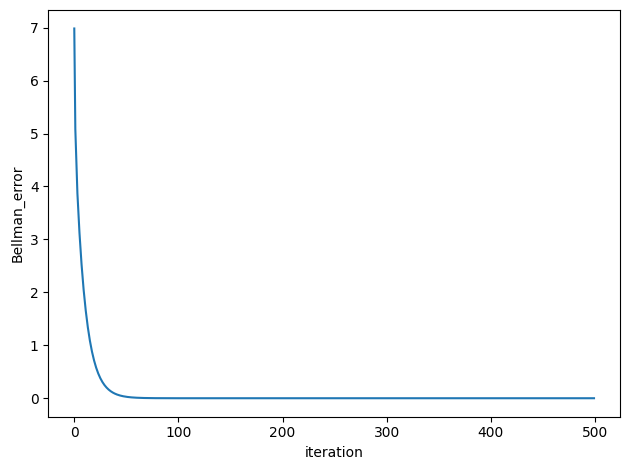

In [12]:
import matplotlib.pyplot as plt
key = jax.random.PRNGKey(0)

S,A = mdp.S, mdp.A

pi = jax.random.uniform(key=key,shape=(S,A))
pi = pi / jnp.sum(pi,axis=1,keepdims=True)
q_before = jax.random.uniform(key = key,shape = (S,A))
errors = []
iteration = 500
for i in range(iteration):
        
        q_after = Bellman_entropy_operator(mdp,q_before,)
        print
        errors.append(np.abs(q_after - q_before).max())
        q_before = q_after
    
plt.plot(np.arange(iteration),errors)



plt.ylabel('Bellman_error')
plt.xlabel('iteration')
plt.tight_layout()